# Neural Networks with PyTorch

In this assignment, we are going to train a Neural Networks on the Japanese MNIST dataset. It is composed of 70000 images of handwritten Hiragana characters. The target variables has 10 different classes.

Each image is of dimension 28 by 28. But we will flatten them to form a dataset composed of vectors of dimension (784, 1). The training process will be similar as for a structured dataset.

<img src='https://drive.google.com/uc?id=16TqEl9ESfXYbUpVafXD6h5UpJYGKfMxE' width="500" height="200">

Your goal is to run at least 3 experiments and get a model that can achieve 80% accuracy with not much overfitting on this dataset.

Some of the code have already been defined for you. You need only to add your code in the sections specified (marked with **TODO**). Some assert statements have been added to verify the expected outputs are correct. If it does throw an error, this means your implementation is behaving as expected.

Note: You can only use fully-connected and dropout layers for this assignment. You can not convolution layers for instance

# 1. Import Required Packages

[1.1] We are going to use numpy, matplotlib and google.colab packages

In [1]:
# Mount Google Drive and import required libraries
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# 2. Download Dataset

We will store the dataset into your personal Google Drive.


[2.1] Mount Google Drive

In [2]:
# Mount Google Drive to access dataset or save outputs
drive.mount('/content/gdrive')

Mounted at /content/gdrive


[2.2] Create a folder called `DL_ASG_1` on your Google Drive at the root level

In [3]:
# Create a directory in Google Drive to store or access assignment files
! mkdir -p /content/gdrive/MyDrive/DL_ASG_1

[2.3] Navigate to this folder

In [4]:
# Navigate to the working directory in Google Drive where dataset files are stored
%cd '/content/gdrive/MyDrive/DL_ASG_1'

/content/gdrive/MyDrive/DL_ASG_1


[2.4] Show the list of item on the folder



In [5]:
# Show the list of items in the current working directory
!ls

kmnist-test-imgs.npz  kmnist-test-labels.npz  kmnist-train-imgs.npz  kmnist-train-labels.npz


[2.4] Dowload the dataset files to your Google Drive if required

In [6]:
# Download the dataset files to your Google Drive if required
import requests
from tqdm import tqdm
import os.path

def download_file(url):
    path = url.split('/')[-1]
    if os.path.isfile(path):
        print (f"{path} already exists")
    else:
      r = requests.get(url, stream=True)
      with open(path, 'wb') as f:
          total_length = int(r.headers.get('content-length'))
          print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))
          for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
              if chunk:
                  f.write(chunk)

url_list = [
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'
]

for url in url_list:
    download_file(url)

kmnist-train-imgs.npz already exists
kmnist-train-labels.npz already exists
kmnist-test-imgs.npz already exists
kmnist-test-labels.npz already exists


[2.5] List the content of the folder and confirm files have been dowloaded properly

In [7]:
# This is a simple validation step to ensure that the downloads in [2.4] completed successfully.
! ls

kmnist-test-imgs.npz  kmnist-test-labels.npz  kmnist-train-imgs.npz  kmnist-train-labels.npz


# 3. Load Data

[3.1] Import the required modules from PyTorch

In [8]:
# Import the required modules from PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

[3.2] **TODO** Create 2 variables called `img_height` and `img_width` that will both take the value 28

In [9]:
# Set image dimensions for KMNIST dataset
img_height = 28
img_width = 28

[3.3] Create a function that loads a .npz file using numpy and return the content of the `arr_0` key

In [10]:
# Helper function to load .npz data
# Each .npz file contains an array under the key 'arr_0'
def load(f):
    return np.load(f)['arr_0']

[3.4] **TODO** Load the 4 files saved on your Google Drive into their respective variables: x_train, y_train, x_test and y_test

In [11]:
# Load KMNIST train/test images and labels
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

[3.5] **TODO** Using matplotlib display the first image from the train set and its target value

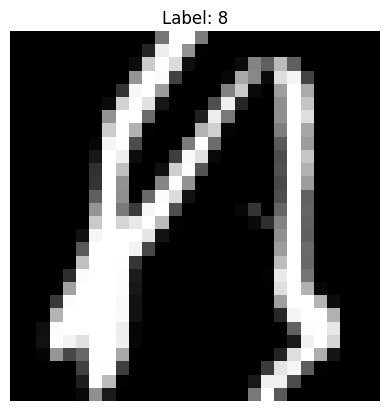

In [12]:
# Display the first training image and its corresponding label
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

# 4. Prepare Data

[4.1] **TODO** Reshape the images from the training and testing set to have the channel dimension last. The dimensions should be: (row_number, height, width, channel)

In [13]:
# Reshape the data to add a channel dimension (for grayscale images)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

[4.2] **TODO** Cast `x_train` and `x_test` into `float32` decimals

In [14]:
# Convert image arrays to float32 before normalization
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

[4.3] **TODO** Standardise the images of the training and testing sets. Originally each image contains pixels with value ranging from 0 to 255. after standardisation, the new value range should be from 0 to 1.

In [15]:
# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images to shape (num_samples, 784)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

[4.4] **TODO** Create a variable called `num_classes` that will take the value 10 which corresponds to the number of classes for the target variable

In [16]:
# Set number of output classes (10 Hiragana characters)
num_classes = 10

[4.5] **TODO** Convert the target variable for the training and testing sets to a binary class matrix of dimension (rows, num_classes).

For example:
- class 0 will become [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- class 1 will become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
- class 5 will become [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
- class 9 will become [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [17]:
# Convert label arrays to PyTorch tensors with Long data type
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 5. Define Neural Networks Architecure

[5.1] Set the seed in PyTorch for reproducing results



In [18]:
# Set seed for reproducibility
torch.manual_seed(42)

[5.2] **TODO** Define the architecture of your Neural Networks and save it into a variable called `model`

In [19]:
# Define a deeper neural network architecture (Experiment 2)
# This model includes 3 hidden layers and higher dropout to test generalization
# - Input size: 784 (flattened 28x28 image)
# - First hidden layer: 512 neurons + ReLU + 30% dropout
# - Second hidden layer: 256 neurons + ReLU + 30% dropout
# - Third hidden layer: 128 neurons + ReLU + 20% dropout
# - Output layer: 10 neurons (for 10 KMNIST classes)
# This architecture helps to explore the impact of network depth on accuracy and overfitting.
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, num_classes)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

[5.2] **TODO** Print the summary of your model

In [20]:
# Print model structure
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=128, out_features=10, bias=True)
)


# 6. Train Neural Networks

[6.1] **TODO** Create 2 variables called `batch_size` and `epochs` that will  respectively take the values 128 and 500

In [21]:
# Define training hyperparameters
# batch_size controls the number of samples per gradient update
# epochs are the number of complete passes through the training dataset
batch_size = 128
epochs = 500

[6.2] **TODO** Compile your model with the appropriate loss function, the optimiser of your choice and the accuracy metric

In [22]:
# Compile model with loss function, optimizer, and accuracy setup
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert training data to PyTorch tensors and move to device
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Wrap data into DataLoader for mini-batch training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

<ipython-input-22-d0bd4f9cf251>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


[6.3] **TODO** Train your model
using the number of epochs defined. Calculate the total loss and save it to a variable called total_loss.

In [23]:
#Training loop: trains the model for multiple epochs and tracks loss and accuracy
total_loss = []

for epoch in range(epochs):  # Iterate through each epoch
    model.train()  # Set model to training mode to enable dropout
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:  # Iterate through training batches
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)  # Forward pass: compute model output
        loss = loss_fn(outputs, targets)  # Compute the loss between prediction and ground truth

        optimizer.zero_grad()  # Clear gradients from previous step
        loss.backward()  # Backpropagate the error
        optimizer.step()  # Update model weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class from output scores
        total += targets.size(0)  # Count total number of samples processed
        correct += (predicted == targets).sum().item()  # Count correctly predicted samples

    avg_loss = running_loss / len(train_loader)  # Calculate average loss for this epoch
    accuracy = 100 * correct / total  # Calculate accuracy percentage for this epoch
    total_loss.append(avg_loss)  # Store the average loss to plot learning curve later

    if (epoch + 1) % 10 == 0 or epoch == 0:  # Print progress every 10 epochs or first epoch
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")

Epoch [1/500] - Loss: 0.5345 - Accuracy: 83.19%
Epoch [10/500] - Loss: 0.0625 - Accuracy: 97.99%
Epoch [20/500] - Loss: 0.0389 - Accuracy: 98.77%
Epoch [30/500] - Loss: 0.0272 - Accuracy: 99.15%
Epoch [40/500] - Loss: 0.0254 - Accuracy: 99.18%
Epoch [50/500] - Loss: 0.0199 - Accuracy: 99.39%
Epoch [60/500] - Loss: 0.0215 - Accuracy: 99.38%
Epoch [70/500] - Loss: 0.0172 - Accuracy: 99.45%
Epoch [80/500] - Loss: 0.0178 - Accuracy: 99.49%
Epoch [90/500] - Loss: 0.0157 - Accuracy: 99.53%
Epoch [100/500] - Loss: 0.0142 - Accuracy: 99.59%
Epoch [110/500] - Loss: 0.0155 - Accuracy: 99.58%
Epoch [120/500] - Loss: 0.0129 - Accuracy: 99.60%
Epoch [130/500] - Loss: 0.0141 - Accuracy: 99.60%
Epoch [140/500] - Loss: 0.0127 - Accuracy: 99.66%
Epoch [150/500] - Loss: 0.0136 - Accuracy: 99.66%
Epoch [160/500] - Loss: 0.0129 - Accuracy: 99.64%
Epoch [170/500] - Loss: 0.0117 - Accuracy: 99.68%
Epoch [180/500] - Loss: 0.0112 - Accuracy: 99.70%
Epoch [190/500] - Loss: 0.0107 - Accuracy: 99.70%
Epoch [200/

[6.4] **TODO** Test your model.  Initiate the model.eval() along with torch.no_grad() to turn off the gradients.


In [24]:
# Evaluate model performance on test set
# Set model to evaluation mode to disable dropout and use learned weights
model.eval()

# Convert test features to float tensor and move to device
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
# Ensure labels are already in tensor form and move to device
y_test_tensor = y_test.to(device)

# Wrap test data into a DataLoader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize counters for accuracy computation
correct = 0
total = 0

# Disable gradient tracking for faster and memory-efficient inference
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get class with highest score
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate and print overall test accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.51%


# 7. Analyse Results

[7.1] **TODO** Display the performance of your model on the training and testing sets

In [25]:
# Display final training and testing accuracy
print(f"Final Training Accuracy: {accuracy:.2f}%")  # From last epoch of training loop
print(f"Final Test Accuracy: {test_accuracy:.2f}%")  # From evaluation section

Final Training Accuracy: 99.81%
Final Test Accuracy: 92.51%


[7.2] **TODO** Plot the learning curve of your model

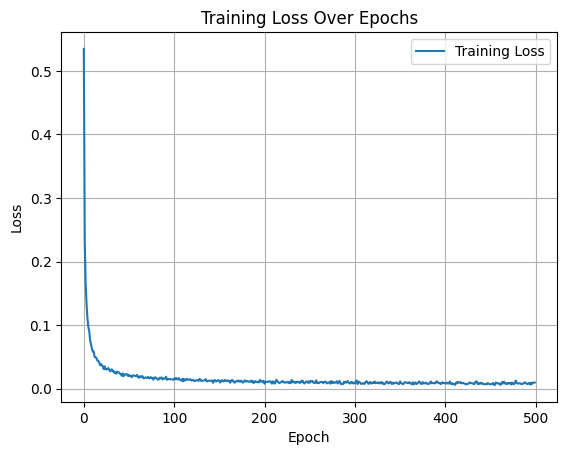

In [26]:
# Plot training loss over time
# Plot the average training loss recorded after each epoch to visualize the learning curve.
# This shows how well the model is learning over time and whether it's converging or not.
import matplotlib.pyplot as plt

plt.plot(total_loss, label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

[7.3] **TODO** Display the confusion matrix on the testing set predictions

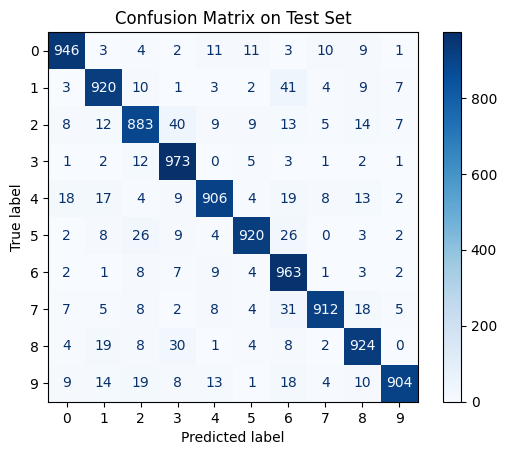

In [27]:
# Generate and display confusion matrix to visualize model performance across all classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix from predictions and true labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Create display object for visualization
disp.plot(cmap='Blues')  # Plot the confusion matrix using a blue color map
plt.title("Confusion Matrix on Test Set")
plt.show()